<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/mbp_aki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 술 중 혈압에 따른 AKI 발생 위험
본 예제에서는 오픈 데이터셋인 vitaldb 를 이용하여 술 중 혈압에 따른 급성 신손상 (acute kidney injury, AKI) 발생 위험을 구해보겠습니다.

## 필요 라이브러리 및 데이터 다운로드

In [ ]:
import pandas as pd
import numpy as np

df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # 임상 정보
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # 트랙 목록
df_labs = pd.read_csv('https://api.vitaldb.net/labs')
df_cases

,caseid,death_inhosp,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,devices,tracks,casedur,filesize,age,sex,height,weight,bmi,asa,emop,department,optype,dx,opname,approach,position,ane_type,opdur,anedur,los_postop,los_icu,preop_htn,preop_dm,preop_ecg,preop_pft,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_glucose,preop_alb,preop_got,preop_gpt,preop_bun,preop_cr,preop_ph,preop_hco3,preop_be,preop_pao2,preop_paco2,preop_spo2,cormack,airway,tubesize,dltubesize,lmasize,iv1,iv2,aline1,aline2,cline1,cline2,intraop_ebl,intraop_uo,intraop_rbc,intraop_ffp,intraop_crystalloid,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
0,1,0,0,11520,-540,10860,-540,10380,-236220,627780,4,78,192,21.3,77.0,M,160.2,67.50,26.3,2.0,0,General surgery,Colorectal,Rectal cancer,Low anterior resection,Open,Lithotomy,General,145,180,8,0,1,0,Normal Sinus Rhythm,Normal,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Right forearm,N,Left radial,N,N,N,NaN,300.0,0,0,350.0,0,120,0.0,100,70,0,10,0,0,0
1,2,0,0,15720,-1020,14940,1740,14640,-221160,1506840,5,75,262,26.3,54.0,M,167.3,54.80,19.6,2.0,0,General surgery,Stomach,Advanced gastric cancer,Subtotal gastrectomy,Open,Supine,General,215,245,19,0,0,0,Normal Sinus Rhythm,Normal,10.2,251.0,110.0,31.9,143.0,4.7,88.0,3.8,18.0,15.0,14.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,N,N,N,N,N,50.0,700.0,0,0,800.0,0,150,0.0,0,100,0,20,0,0,0
2,3,0,0,4440,-540,4260,-540,3960,-218640,40560,5,80,73,6.6,62.0,M,169.1,69.70,24.4,1.0,0,General surgery,Biliary/Pancreas,Gallbladder stone,Cholecystectomy,Videoscopic,Reverse Trendelenburg,General,32,65,2,0,0,0,Normal Sinus Rhythm,Normal,14.2,373.0,103.0,30.3,144.0,4.9,87.0,4.2,17.0,34.0,14.0,1.18,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,N,N,N,N,N,NaN,NaN,0,0,200.0,0,0,0.0,0,50,0,0,0,0,0
3,4,0,0,21000,-720,20280,2580,18180,-201120,576480,5,74,350,28.3,74.0,M,160.6,53.00,20.5,2.0,0,General surgery,Stomach,Advanced gastric cancer,Distal gastrectomy,Videoscopic,Reverse Trendelenburg,General,255,335,7,1,1,0,Normal Sinus Rhythm,Normal,14.4,275.0,103.0,34.5,141.0,4.2,108.0,4.1,23.0,18.0,10.0,0.96,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,NaN,NaN,NaN,Left forearm,N,Right radial,N,N,N,NaN,270.0,0,0,2700.0,0,80,0.0,100,100,0,50,0,0,0
4,5,0,0,21540,-960,22440,2640,21840,-67560,3734040,6,99,359,41.0,66.0,M,171.0,59.70,20.4,3.0,1,General surgery,Vascular,Aortic aneurysm,Aneurysmal repair,Open,Prone,General,295,350,45,13,1,0,Left anterior fascicular block,Normal,10.1,67.0,73.0,36.5,146.0,4.4,126.0,2.6,765.0,77.0,50.0,4.43,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Right forearm,N,Right radial,N,Right IJV,N,2600.0,1490.0,8,8,7100.0,0,0,0.0,0,160,0,10,900,0,2100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6383,6384,0,0,15240,-240,15660,-240,15060,-215340,648660,5,73,254,9.3,64.0,M,161.5,63.00,24.2,1.0,0,General surgery,Stomach,Advanced gastric cancer,Total gastrectomy,Open,Supine,General,200,245,8,0,0,0,Normal Sinus Rhythm,Normal,14.5,279.0,109.0,31.0,NaN,NaN,100.0,4.2,31.0,33.0,13.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,N,N,N,N,N,100.0,330.0,0,0,550.0,0,150,0.0,0,90,0,20,0,0,0
6384,6385,0,0,20640,-540,21000,-540,19800,-225600,1675200,5,76,344,29.0,69.0,M,159.3,62.30,24.6,2.0,0,General surgery,Colorectal,"Colon submucosal tumor, unknown behavior",Ultralow anterior resection,Videoscopic,Lithotomy,General,285,335,20,0,1,0,Normal Sinus Rhythm,Normal,15.2,239.0,114.0,28.7,144.0,4.0,140.0,3.7,18.0,28.0,19.0,0.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.5,NaN,NaN,Right forearm,Left forearm,Right radial,N,N,N,100.0,250.0,0,0,2500.0,0,100,0.0,0,

## 본 예제에서 사용할 case 선택
응급 외과 수술 환자 중 100명만 사용해보자.

In [ ]:
caseids = list(
    set(df_trks[df_trks['tname'] == 'Solar8000/ART_MBP']['caseid']) & 
    set(df_cases[df_cases['department'] == 'General surgery']['caseid']) &
    set(df_cases[df_cases['emop'] == 1]['caseid'])
)
caseids = caseids[:100]
print('Total {} cases found'.format(len(caseids)))

Total 100 cases found


## 각 케이스별 데이터 받아오기 및 계산
vitaldb 로부터 각 case별 술 전 creatinine 농도 및 술 후 creatinine 농도를 구해보고 이로부터 AKI 발생 여부를 구해보자. 또한 수술 중 ART_MBP 데이터를 받아와 40-80 mmHg 의 각 threshold 들에 대해 전체 수술 중 해당 threshold  이하에 머무른 측정치의 비율을 구해보자.

In [ ]:
# 혈압 기준치
mbp_thresholds = np.arange(40, 80)

# 최종 결과 저장
df = pd.DataFrame()
for caseid in caseids:
    print('loading {}...'.format(caseid), flush=True, end='')

    # 마취 종료 시각을 가져옴
    aneend = df_cases[(df_cases['caseid'] == caseid)]['aneend'].values[0]

    # 술 전 마지막 creatinine 농도
    preop_cr = df_labs[(df_labs['caseid'] == caseid) & (df_labs['dt'] < 0) & (df_labs['name'] == 'Creatinine')].sort_values(by=['dt'], axis=0, ascending=False)['result'].values.flatten()
    if len(preop_cr) == 0:
        print('no preop cr')
        continue
    preop_cr = preop_cr[0]

    # 술 후 48 시간 최대 creatinine 농도
    postop_cr = df_labs[(df_labs['caseid'] == caseid) & (df_labs['dt'] > aneend) &
        (df_labs['dt'] < aneend + 48 * 3600) & (df_labs['name'] == 'Creatinine')]['result'].max(skipna=True)
    if not postop_cr or np.isnan(postop_cr):
        print('no postop cr')
        continue

    # KDIGO stage I
    aki = postop_cr > preop_cr * 1.5

    # 술 중 혈압
    tid_mbp = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/ART_MBP')]['tid'].values[0]
    mbps = pd.read_csv('https://api.vitaldb.net/' + tid_mbp).values[:,1]
    mbps = mbps[~np.isnan(mbps)]
    mbps = mbps[(mbps > 20) & (mbps < 150)]
    if len(mbps) < 10:
        print('no mbp')
        continue

    # 수술 중 혈압을 1단위로 증가시키면서 해당 시간 동안 머무른 비율을 구함
    row = {'aki':aki}
    for mbp_threshold in mbp_thresholds:
        row['under{}'.format(mbp_threshold)] = np.nanmean(mbps < mbp_threshold) * 100

    # 결과 행에 추가
    df = df.append(row, ignore_index=True)

    print('{} -> {}, {}'.format(preop_cr, postop_cr, 'AKI' if aki else 'no AKI'))

print('{} AKI {:.1f}%'.format(df['aki'].sum(), df['aki'].mean() * 100))

loading 6144...0.5 -> 0.57, no AKI
loading 2063...0.71 -> 1.26, AKI
loading 4112...no postop cr
loading 4115...1.07 -> 0.9, no AKI
loading 4116...0.63 -> 0.72, no AKI
loading 24...no preop cr
loading 29...0.78 -> 0.74, no AKI
loading 32...no postop cr
loading 4135...2.65 -> 2.3, no AKI
loading 4144...17.74 -> 15.82, no AKI
loading 6196...0.82 -> 1.0, no AKI
loading 4150...no postop cr
loading 4155...1.15 -> 2.19, AKI
loading 60...9.36 -> 7.95, no AKI
loading 2117...0.84 -> 0.89, no AKI
loading 4168...0.73 -> 0.62, no AKI
loading 2130...14.8 -> 9.02, no AKI
loading 83...8.13 -> 7.36, no AKI
loading 87...2.72 -> 2.35, no AKI
loading 2138...no postop cr
loading 2147...0.44 -> 0.52, no AKI
loading 4195...0.89 -> 0.96, no AKI
loading 2157...0.78 -> 0.74, no AKI
loading 4213...0.88 -> 0.66, no AKI
loading 6262...no preop cr
loading 124...0.63 -> 0.63, no AKI
loading 2174...5.42 -> 4.63, no AKI
loading 4225...no postop cr
loading 6273...no preop cr
loading 138...0.72 -> 0.65, no AKI
loading 6

## 각 혈압 기준치별로 AKI 예측에 대한 odd ratio를 구함
case 별 AKI 발생 여부 및 각 threshold 에 머무른 비율을 이용하여 각 혈압 기준치가 AKI 발생 risk 를 얼마나 증가시키는지 odd ratio 를 구해보자.

In [ ]:
import statsmodels.api as sm

# univariate logistic regression을 돌려 odd ratio 를 구함
df['intercept'] = 1
df['aki'] = df['aki'].astype(bool)
odd_ratios = []
for mbp_threshold in mbp_thresholds:
    c = 'under{}'.format(mbp_threshold)
    model = sm.Logit(df['aki'], df[['intercept', c]])
    res = model.fit()
    b = res.params[c]
    pval = res.pvalues[c]
    odd_ratios.append(np.exp(b))
    print('{}\tb={:.3f}, exp(b)={:.3f}, pval={:.3f}'.format(c, b, np.exp(b), pval))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.281467
         Iterations 7
under40	b=0.305, exp(b)=1.357, pval=0.042
Optimization terminated successfully.
         Current function value: 0.277493
         Iterations 7
under41	b=0.297, exp(b)=1.346, pval=0.030
Optimization terminated successfully.
         Current function value: 0.275000
         Iterations 7
under42	b=0.278, exp(b)=1.321, pval=0.027
Optimization terminated successfully.
         Current function value: 0.274872
         Iterations 7
under43	b=0.253, exp(b)=1.288, pval=0.030
Optimization terminated successfully.
         Current function value: 0.272730
         Iterations 7
under44	b=0.238, exp(b)=1.269, pval=0.027
Optimization terminated successfully.
         Current function value: 0.266457
         Iterations 7
under45	b=0.228, exp(b)=1.257, pval=0.017
Optimization terminated successfully.
         Current function value: 0.261914
         Iterations 7
under46	b=0.202, exp(b)=1.224, pva

## 결과를 그림으로
대략 MBP가 60-65mmHg 이하로 머무르는 시간이 늘어날 수록 AKI 의 odd ratio가 증가함을 알 수 있다.

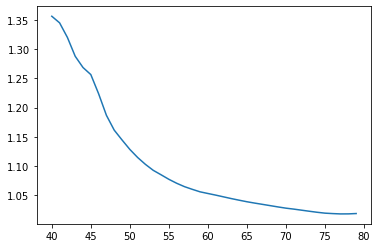

In [ ]:
import matplotlib.pyplot as plt

# 결과를 그림으로
plt.plot(mbp_thresholds, odd_ratios)
plt.show()